In [42]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [46]:
rcParams["figure.facecolor"] = "none"
rcParams["axes.facecolor"] = "none"

In [2]:
# good : 5
np.random.seed(27)

In [3]:
n_regions = 2

#rs = np.array([[0.05,0.6],[0.2,-0.1]])
rs = np.array([[0.2,0.8],[0.1,-0.3]])
rs

array([[ 0.2,  0.8],
       [ 0.1, -0.3]])

In [4]:
x0 = np.array([5000,100])

In [626]:
#x0 = np.random.randint(100,1000,size = 4)

In [5]:
def fun(y,t,rs):
    dydt = np.zeros(n_regions)
    for ii in range(n_regions):
        for jj in range(n_regions):
            if ii != jj:
                add = y[jj]*rs[jj,ii] - y[ii]*rs[ii,jj]
            else:
                add = y[ii]*rs[ii,ii]
            dydt[ii] += add
    return dydt
    

In [6]:
time = np.linspace(0,5,1000)


In [7]:
soln = odeint(fun,x0,time,args = (rs,))

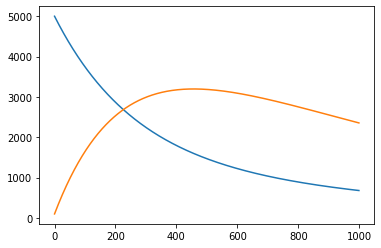

In [8]:
plt.plot(soln)
plt.show()

In [9]:
from scipy.optimize import leastsq,minimize
from scipy import integrate
class ODE_solver:
    def __init__(self,
                 time,
                 y,
                 y0,
                 n_regions,
                ):
        self.n_regions = n_regions
        self.time = time
        self.y = y
        self.N = self.y.shape[0]
        self.y0 = y0
    def ode(self, y, t, p):
        dydt = np.zeros(self.n_regions)
        rs = p.reshape(self.n_regions,self.n_regions)
        for ii in range(n_regions):
            for jj in range(n_regions):
                if ii != jj:
                    add = y[jj]*rs[jj,ii] - y[ii]*rs[ii,jj]
                else:
                    add = y[ii]*rs[ii,ii]
                dydt[ii] += add
        return dydt

    def model(self,t, p):
        y_new = integrate.odeint(self.ode, self.y0, t, args=(p,))
        return y_new

    def min_fun(self, p):
        return np.mean((self.y.flatten() - self.model(self.time, p).flatten())**2)

    def optim(self, p_guess):
        return minimize(self.min_fun, p_guess)


In [10]:
odes = ODE_solver(time,soln,x0,n_regions)
prms = odes.optim(np.zeros(n_regions*n_regions))

In [11]:
pred_r = prms["x"].reshape(n_regions,n_regions)

In [12]:
pred_r,rs

(array([[ 0.19999995,  0.79999991],
        [ 0.09999996, -0.29999998]]),
 array([[ 0.2,  0.8],
        [ 0.1, -0.3]]))

(-0.5, 1.5, 1.5, -0.5)

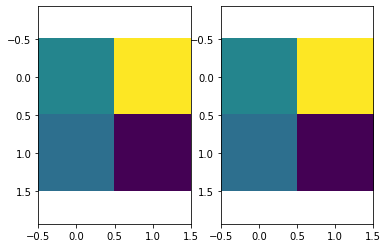

In [634]:
vmin = min(pred_r.min(),rs.min())
vmax = max(pred_r.max(),rs.max())
plt.subplot(121)
plt.imshow(rs,vmin = vmin,vmax = vmax)
plt.axis("equal")
plt.subplot(122)
plt.imshow(pred_r,vmin = vmin,vmax = vmax)
plt.axis("equal")

## spatial

In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    
import preprocess as pp

In [14]:
TEST_PTH = "/home/alma/w-projects/ccf/rsc/ref/2comp_2/ref.png"

In [15]:
from PIL import Image
img = Image.open(TEST_PTH)

In [16]:
crd,meta = pp.reference_to_grid(img,n_approx_points=1000,
                           background_color="white",
                           n_regions=2,
                           )

[1 2]


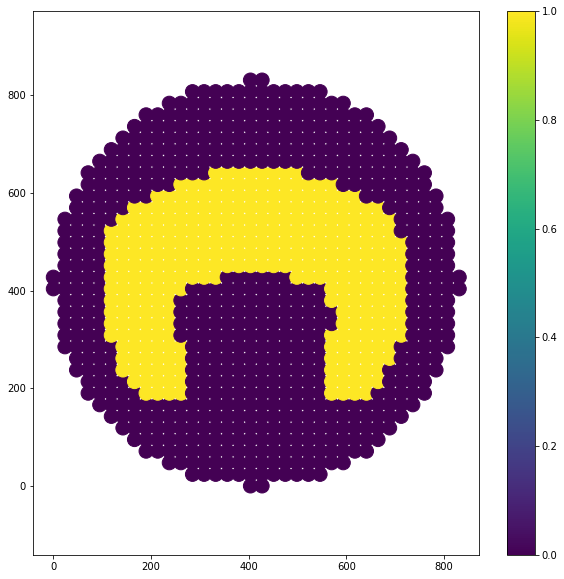

In [17]:
plt.figure(figsize=(10,10))
sc = plt.scatter(crd[:,0],crd[:,1],s = 200,c = meta)
plt.axis("equal")
plt.colorbar(sc)
plt.show()

NameError: name 'counts' is not defined

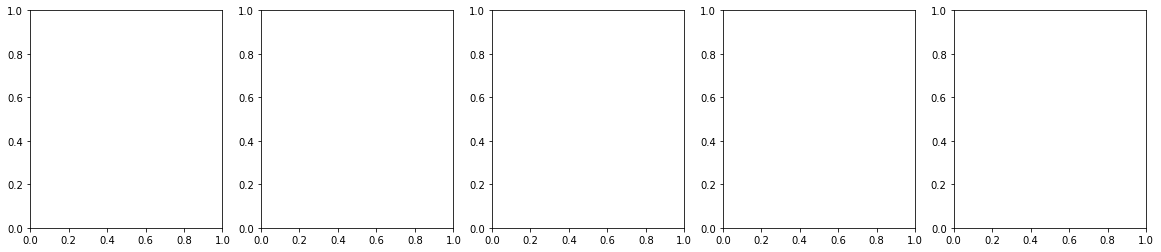

In [19]:
sel_times = np.linspace(0,150-1,5).round().astype(int)
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

for k in range(len(ax)):
    ax[k].scatter(crd[:,0],
                  crd[:,1],
                  c = counts[:,sel_times[k]],
                  s = 20)
    ax[k].set_aspect("equal")

## generate time series data

In [20]:
import os.path as osp

DIR = "/home/alma/w-projects/ccf/rsc/ref/2comp_2/"
LMK_DIR = osp.join(DIR,"landmarks")
img_paths = [osp.join(DIR,"t_{}.png".format(x)) for x in range(0,8)]
lmk_paths = [osp.join(LMK_DIR,"t_{}_landmarks.tsv".format(x)) for x in range(0,8)]

In [21]:
sel_times

array([  0,  37,  74, 112, 149])

[0 1]


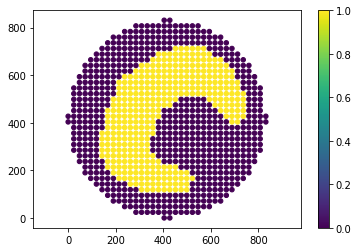

[0 1]


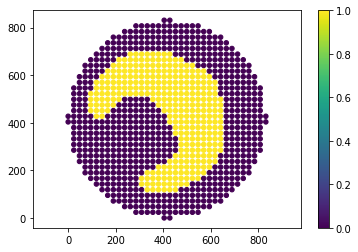

[0 1]


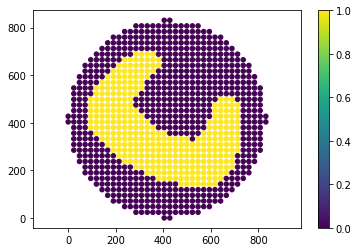

[1 2]


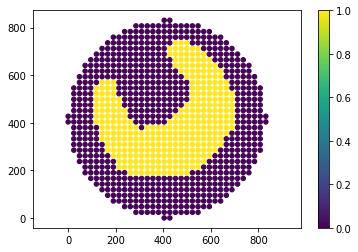

[0 1]


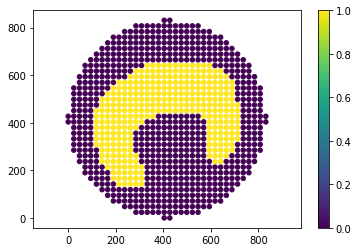

[0 1]


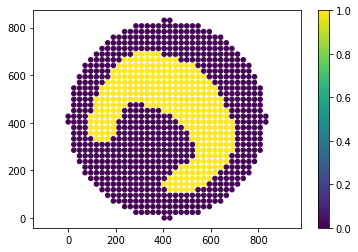

[1 2]


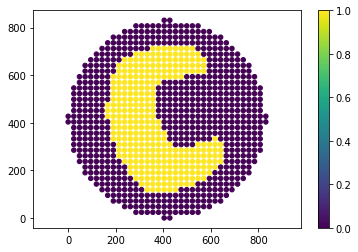

[0 1]


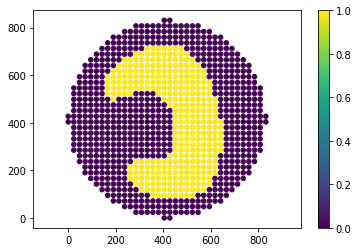

In [22]:
from PIL import Image
sel_times = np.linspace(0,int(len(time) / 2),8).round().astype(int)
new_int_soln = soln
crds = list()
counts = list()
lmks = list()
for ii,(img_pth,lmk_pth,t) in enumerate(zip(img_paths,lmk_paths,sel_times)):
    lmk = pd.read_csv(lmk_pth,sep = "\t",header = 0,index_col = 0)
    lmks.append(lmk)
    img = Image.open(img_pth)
    crd,meta = pp.reference_to_grid(img,n_approx_points=1000,
                               background_color="white",
                               n_regions=2,
                               )
    
    count = np.zeros(crd.shape[0])

    for k,reg in enumerate(np.unique(meta)):
        idx = np.where(meta == reg)[0]
        sel = np.random.choice(idx,
                               replace = True,
                               size = int(new_int_soln[t,k]))
        for s in sel:
            count[s] +=1
            
    crds.append(crd)
    counts.append(count)
    sc = plt.scatter(crd[:,0],
                     crd[:,1],
                     c = meta,
                     s = 20)
    plt.axis("equal")
    plt.colorbar(sc)
    plt.show()

In [26]:
ref_lmk_pth = osp.join(DIR,"landmarks","ref_landmarks.tsv")
ref_img_pth = osp.join(DIR,"ref.png")
ref_lmk = pd.read_csv(ref_lmk_pth,sep = "\t",header = 0,index_col = 0)
ref_img = Image.open(ref_img_pth)
ref_crd,ref_meta = pp.reference_to_grid(ref_img,n_approx_points=1000,
                           background_color="white",
                           n_regions=2,
                           )



[0 1]


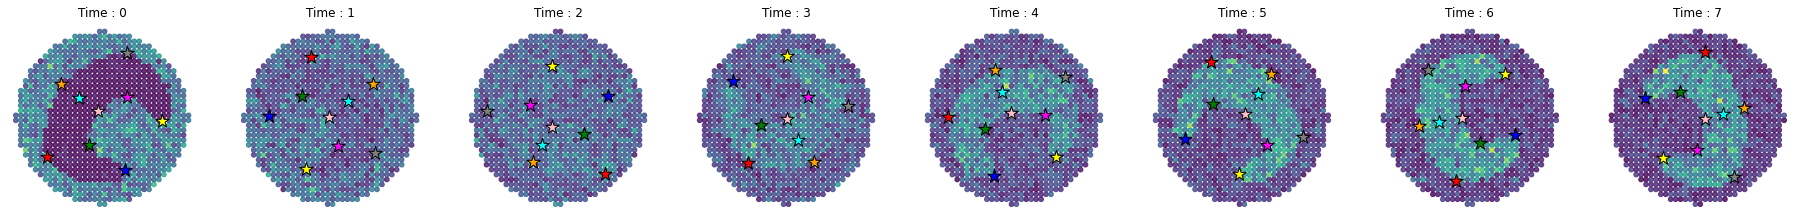

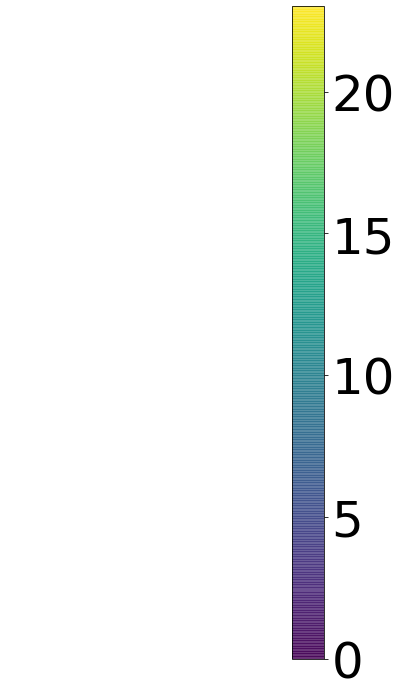

In [60]:
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

cmap = {0:"orange",
        1:"red",
        2:"blue",
        3:"green",
        4:"pink",
        5:"magenta",
        6:"yellow",
        7:"gray",
        8:"cyan"}

vmin = min([c.min() for c in counts])
vmax = max([c.max() for c in counts])

for k in range(len(sel_times)):
    _sc = ax[k].scatter(crds[k][:,0],
                  crds[k][:,1],
                  c = counts[k],
                  s = 22,
                  cmap = plt.cm.viridis,
                  vmin = vmin,
                  vmax = vmax,
                  alpha = 0.8)


    #fig.colorbar(sc,ax = ax[k],orientation = "horizontal")
    
    for l in range(lmks[k].shape[0]):
        ax[k].scatter(lmks[k].values[l,0],
                      lmks[k].values[l,1],
                      s = 200,
                      marker = "*",
                      c = cmap[l],
                      edgecolor = "black",
                     )
        
    ax[k].set_aspect("equal")
    ax[k].set_yticks([])
    ax[k].set_xticks([])
    ax[k].set_title(f"Time : {k}")
    ax[k].axis("off")
    
fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=50)
plt.show()

In [23]:
import utils as ut
import preprocess as pp

In [27]:
adatas = []
for k in range(len(crds)):
    obs_index = [f"Spot_{x}" for x in range(len(crds[k]))]
    adata = ad.AnnData(counts[k][:,np.newaxis],
                       var = pd.DataFrame(["Gene1"],
                                          columns = ["Gene"],
                                          index = ["Gene1"],
                                         ),
                       obs = pd.DataFrame(index = obs_index)
                      )
    adata.obsm["spatial"] = crds[k]
    adata.uns["curated_landmarks"] = lmks[k]
    pp.get_landmark_distance(adata)
    adatas.append(adata)

/home/alma/w-projects/ccf/src/models.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = self.fwd_coordinate_transform(t.tensor(landmarks))
/home/alma/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '2.6.8' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)


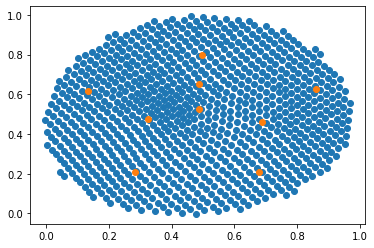

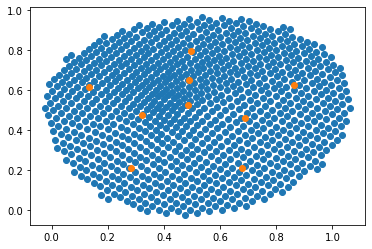

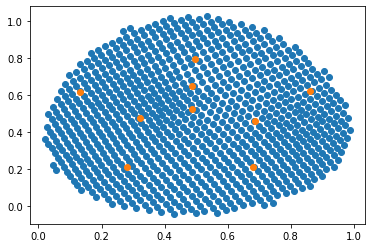

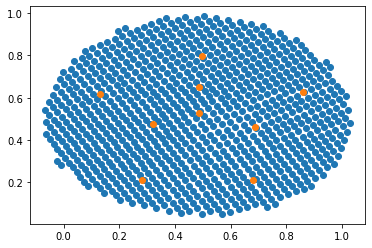

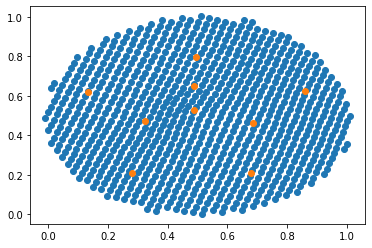

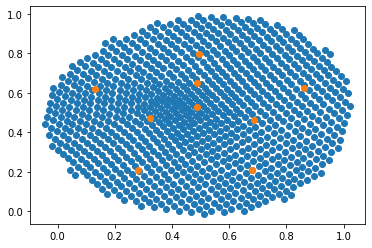

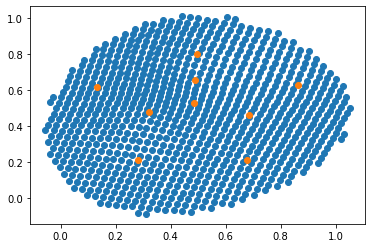

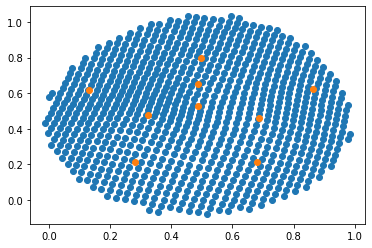

In [28]:
import models as m
import methods as f

ref = m.Reference(ref_crd,
                  landmarks = ref_lmk.values,
                 )

for adata in adatas:
    pp.match_scales(adata,reference=ref)
    pp.get_landmark_distance(adata,reference=ref)



In [29]:
losses = f.map_to_reference(adatas,
                           "Gene1",
                            ref,
                            n_epochs=1000,
                            verbose = True,
                            return_models =False,
                            return_losses = True,
                           )

Processing >> Model : Model_0 | Feature : Gene1


  0%|          | 0/1000 [00:00<?, ?it/s]/home/alma/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]


Processing >> Model : Model_1 | Feature : Gene1


100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s]


Processing >> Model : Model_2 | Feature : Gene1


100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


Processing >> Model : Model_3 | Feature : Gene1


100%|██████████| 1000/1000 [01:01<00:00, 16.23it/s]


Processing >> Model : Model_4 | Feature : Gene1


100%|██████████| 1000/1000 [00:41<00:00, 23.92it/s]


Processing >> Model : Model_5 | Feature : Gene1


100%|██████████| 1000/1000 [00:33<00:00, 30.12it/s]


Processing >> Model : Model_6 | Feature : Gene1


100%|██████████| 1000/1000 [00:37<00:00, 26.83it/s]


Processing >> Model : Model_7 | Feature : Gene1


100%|██████████| 1000/1000 [00:36<00:00, 27.23it/s]


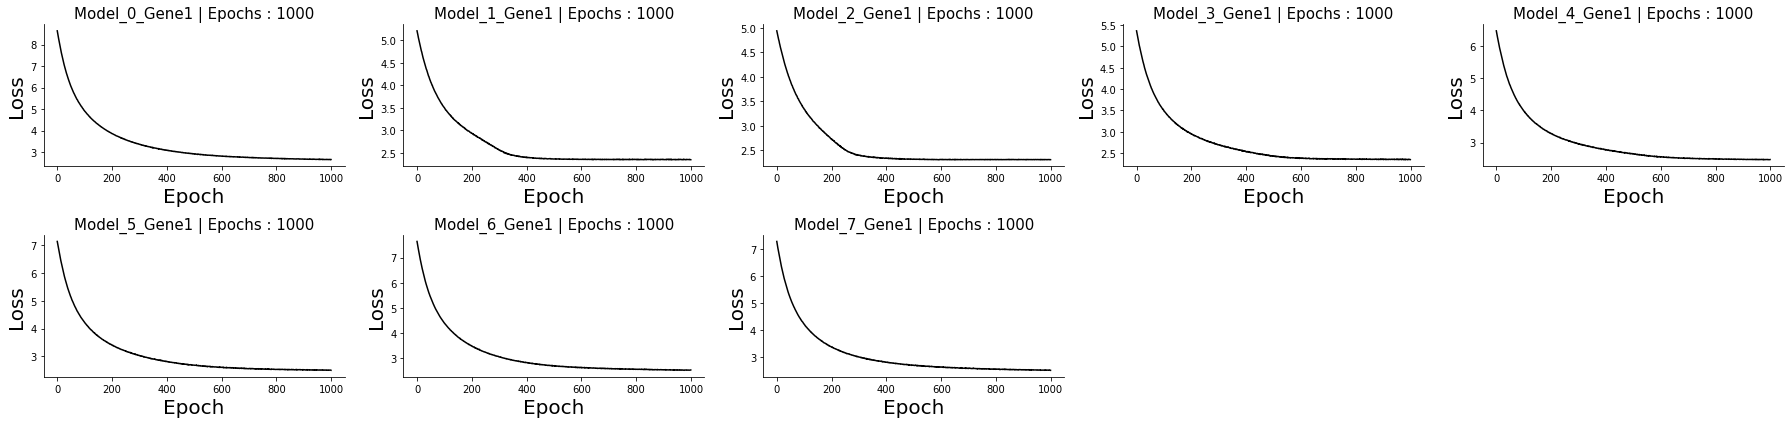

In [30]:
ut.model_diagnostics(losses = losses)

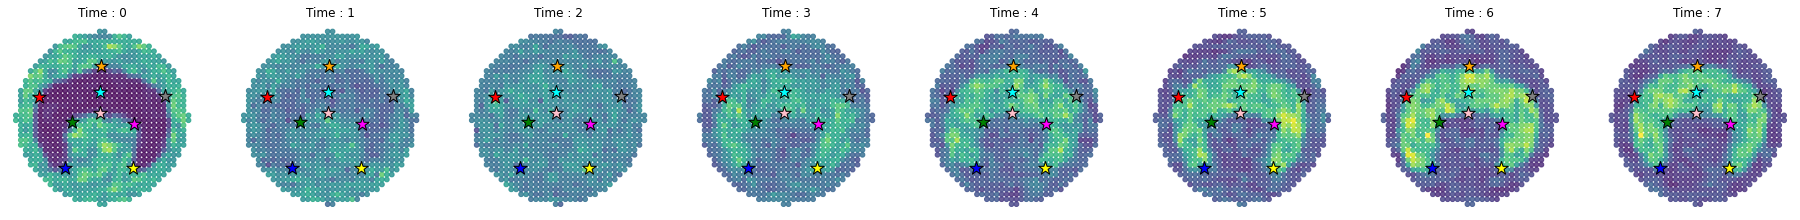

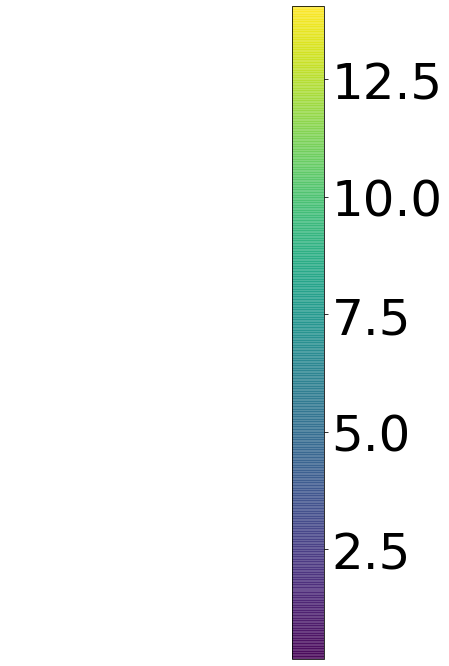

In [59]:
fig,ax = plt.subplots(1,len(sel_times),
                      figsize = (len(sel_times) * 4,4))
ax = ax.flatten()

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

for k in range(len(sel_times)):
    _sc = ax[k].scatter(ref_crd[:,0],ref_crd[:,1],
                  c = ref.adata.X[:,k],
                  s = 22,
                  cmap = plt.cm.viridis,
                  alpha = 0.8,
                  marker = "o",
                  vmin = vmin,
                  vmax = vmax,
                 )
    
    #in_sel = ref_meta == 1
    #ax[k].scatter(ref_crd[in_sel,0],
    #              ref_crd[in_sel,1],
    #              c = "red",
    #              s = 1,
    #              alpha = 1,
    #              marker = ".",
    #              vmin = vmin,
    #              vmax = vmax,
    #             )
    

    #fig.colorbar(sc,ax = ax[k],orientation ="horizontal")
    
    for l in range(ref_lmk.shape[0]):
        ax[k].scatter(ref_lmk.values[l,0],
                      ref_lmk.values[l,1],
                      s = 200,
                      marker = "*",
                      c = cmap[l],
                      edgecolor = "black",
                     )
        
    ax[k].set_aspect("equal")
    ax[k].set_yticks([])
    ax[k].set_xticks([])
    ax[k].set_title(f"Time : {k}")
    ax[k].axis("off")

fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=50)
plt.show()

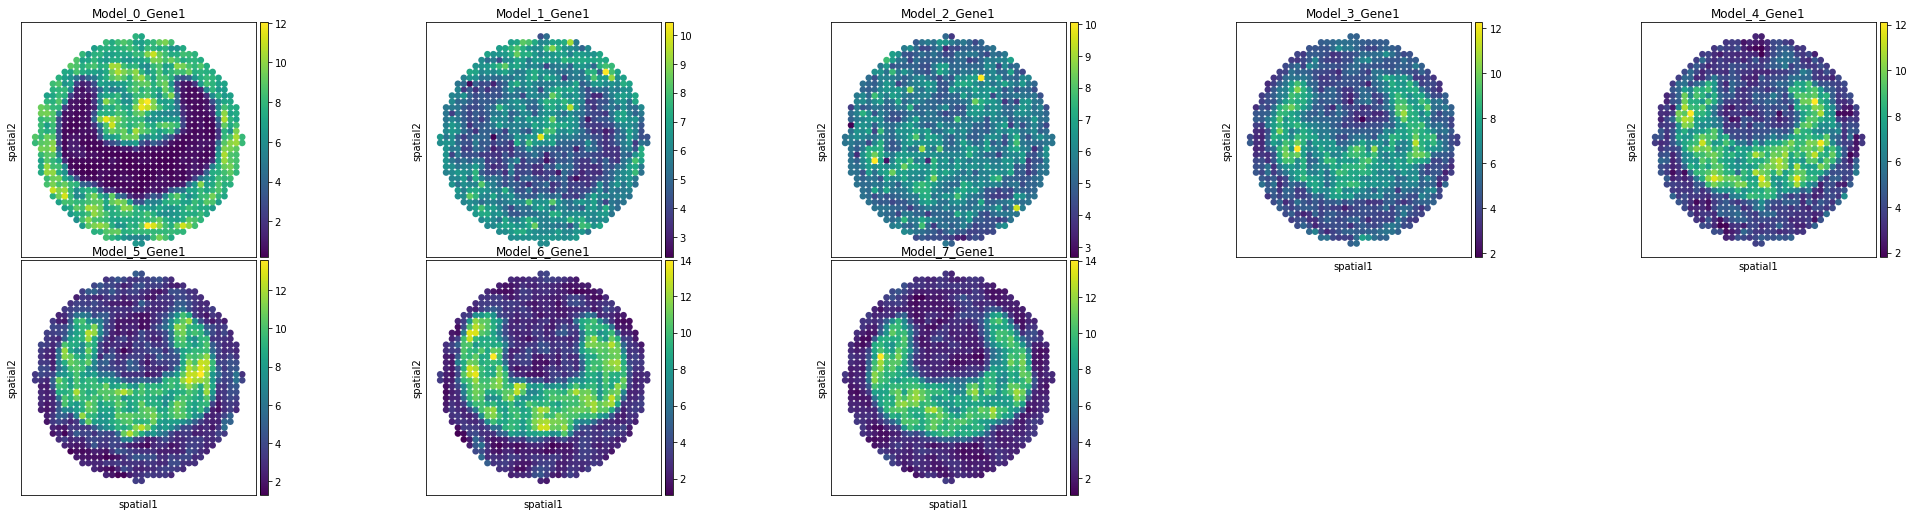

In [34]:
ref.plot(spot_size=0.032,ncols = 5,cmap = plt.cm.viridis,alpha = 1,hspace = 0.01)

## Optical flow stuff

In [805]:
from scipy.spatial.distance import cdist

In [829]:
dmat = cdist(ref.adata.obsm["spatial"],ref.adata.obsm["spatial"])
dmat[dmat == 0] = np.inf
radius = np.floor(dmat.min())

In [953]:
import squidpy as sq
sq.gr.spatial_neighbors(ref.adata,n_neigh=4,coord_type="generic",key_added="spatial_4")
sq.gr.spatial_neighbors(ref.adata,n_neigh=9,coord_type="generic",key_added="spatial_9")

In [951]:
ref.adata

AnnData object with n_obs × n_vars = 959 × 5
    uns: 'spatial_neighbors', 'spatial_connectivities_4_neighbors', 'spatial_connectivities_9_neighbors', 'spatial_4_neighbors', 'spatial__9_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_distances', 'spatial_connectivities_4_distances', 'spatial_connectivities_9_distances', 'spatial_connectivities', 'spatial_connectivities_4_connectivities', 'spatial_connectivities_9_connectivities', 'spatial_4_connectivities', 'spatial_4_distances', 'spatial__9_connectivities', 'spatial__9_distances'

In [908]:
ref.adata.obsp["spatial_connectivities"]

<959x959 sparse matrix of type '<class 'numpy.float64'>'
	with 3836 stored elements in Compressed Sparse Row format>

In [1120]:
crd = ref.adata.obsm["spatial"]
ori_vals = np.array(ref.adata.X)
new_vals = np.zeros(ori_vals.shape)
n_obs,n_features = ref.adata.shape
gr4 = ref.adata.obsp["spatial_4_connectivities"]
for s in range(n_obs):
    ptr = slice(gr4.indptr[s],gr4.indptr[s+1])
    idx = np.append(gr4.indices[ptr],s)
    for g in range(n_features):
        new_vals[s,g] = ori_vals[idx,g].mean()
        

In [1115]:
crd = ref.adata.obsm["spatial"]
vals = new_vals[:,[0,1]]
n_obs = ref.adata.shape[0]
gr4 = ref.adata.obsp["spatial_4_connectivities"]
gr9 = ref.adata.obsp["spatial_9_connectivities"]
satind = np.zeros(n_obs)
dx = np.zeros(n_obs)
dy = np.zeros(n_obs)
dt = np.zeros(n_obs)
flow_vectors = np.zeros((n_obs,2))
for s in range(n_obs):
    ptr = slice(gr4.indptr[s],gr4.indptr[s+1])
    idx = gr4.indices[ptr]
    nbrs = crd[idx,:]
    nbrs_vals = vals[idx,:]
    center = crd[s,:]
    on_x = nbrs[:,1] == center[1]
    on_y = nbrs[:,0] == center[0]
    if sum(on_x) == 2 and sum(on_y) == 2:
        satind[s] = 1
        xvals = nbrs_vals[on_x,:][np.argsort(nbrs[on_x,0]),:].mean(axis=1)
        yvals = nbrs_vals[on_y,:][np.argsort(nbrs[on_y,1]),:].mean(axis=1)
        dx[s] = np.diff(xvals)[0]
        dy[s] = np.diff(yvals)[0]
        dt[s] = vals[s,1] - vals[s,0]
for s in range(n_obs):
    if satind[s] == 1:
        ptr = slice(gr9.indptr[s],gr9.indptr[s+1])
        idx = np.append(gr9.indices[ptr],s)
        A = np.hstack((dx[idx,np.newaxis],dy[idx,np.newaxis]))
        b = -dt[idx]
        v = -np.dot(np.linalg.inv(np.dot(A.T,A)),np.dot(A.T,b))
        flow_vectors[s,:] = v

norm = np.linalg.norm(flow_vectors,axis=1,keepdims=True)
flow_vectors = np.divide(flow_vectors, norm,where = norm.flatten()[:,np.newaxis] > 0)

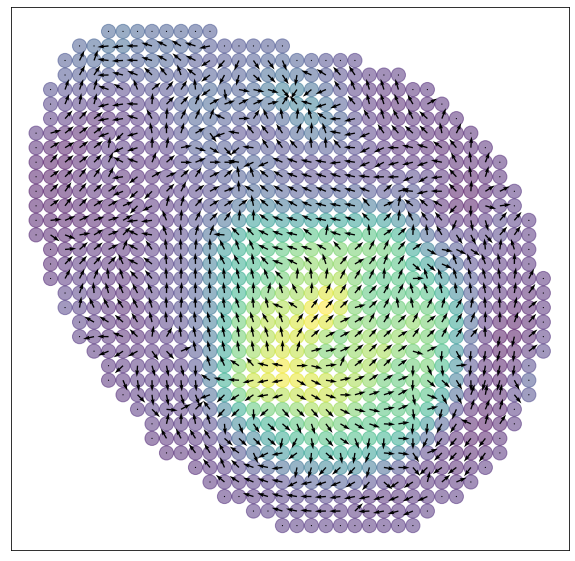

In [1122]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(crd[:,0],crd[:,1],c = ori_vals[:,0], alpha = 0.5,s = 200)
ax.quiver(crd[:,0],crd[:,1],flow_vectors[:,0],flow_vectors[:,1])
ax.set_xticks([])
ax.set_yticks([])

plt.axis("equal")
plt.show()

# import matplotlib.patches as patches

help(patches.Rectangle)

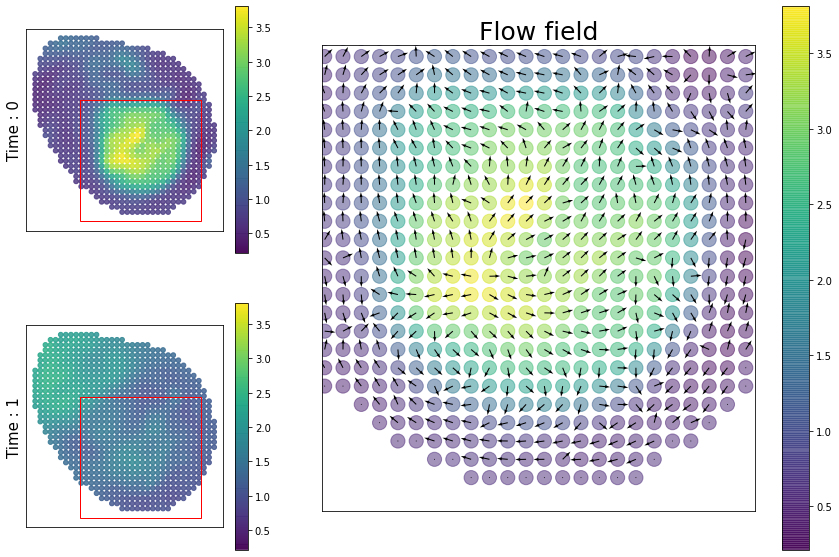

In [1211]:
import matplotlib.patches as patches
mosaic = """
    ABB
    CBB
    """
axd = plt.figure(constrained_layout=True,figsize = (15,10)).subplot_mosaic(mosaic)

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

for t,l in zip([0,1],["A","C"]):
    sc = axd[l].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,t],
                    s = 22,
                    cmap = plt.cm.viridis,
                    alpha = 0.8,
                    marker = "o",
                        vmin = vmin,
                        vmax = vmax,
                    )
    rect = patches.Rectangle((200,20),400,400,
                          linewidth=1,
                           edgecolor='r',
                          facecolor='none')
    axd[l].add_patch(rect)
    axd[l].set_xticks([])
    axd[l].set_yticks([])
    axd[l].set_aspect("equal")
    axd[l].set_ylabel(f"Time : {t}",fontsize = 15)
    fig.colorbar(sc, ax=axd[l])

    
axd["B"].scatter(ref_crd[:,0],ref_crd[:,1],
                 c = ori_vals[:,0],
                 alpha = 0.5,
                 s = 200)
axd["B"].quiver(ref_crd[:,0],
                ref_crd[:,1],
                flow_vectors[:,0],
                flow_vectors[:,1],
                scale = 40,
               )

axd["B"].set_xticks([])
axd["B"].set_yticks([])
axd["B"].set_xlim([200,600])
axd["B"].set_ylim([20,450])
axd["B"].set_title("Flow field",fontsize = 25)
axd["B"].set_aspect("equal")
fig.colorbar(sc, ax=axd["B"])


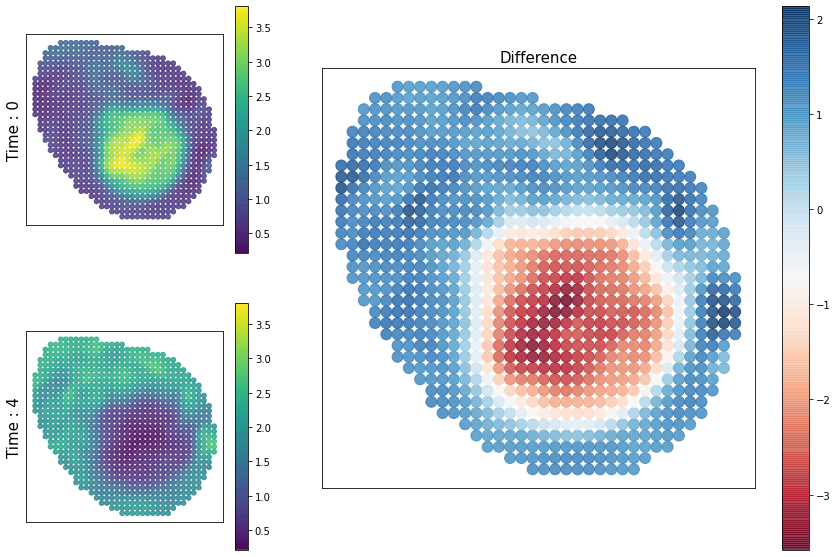

In [1210]:
import matplotlib.patches as patches
mosaic = """
    ABB
    CBB
    """
axd = plt.figure(constrained_layout=True,figsize = (15,10)).subplot_mosaic(mosaic)

vmin = ref.adata.X.min()
vmax = ref.adata.X.max()

timepoints = [0,4]
for t,l in zip(timepoints,["A","C"]):
    sc = axd[l].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,t],
                    s = 22,
                    cmap = plt.cm.viridis,
                    alpha = 0.8,
                    marker = "o",
                    vmin = vmin,
                    vmax = vmax,
                    )
    
    axd[l].set_xticks([])
    axd[l].set_yticks([])
    axd[l].set_aspect("equal")
    axd[l].set_ylabel(f"Time : {t}",fontsize = 15)
    fig.colorbar(sc, ax=axd[l])
    
sc = axd["B"].scatter(ref_crd[:,0],ref_crd[:,1],
                    c = ref.adata.X[:,timepoints[1]] - ref.adata.X[:,timepoints[0]],
                    s = 120,
                    cmap = plt.cm.RdBu,
                    alpha = 0.8,
                    marker = "o",
                    )
    
axd["B"].set_xticks([])
axd["B"].set_yticks([])
axd["B"].set_aspect("equal")
axd["B"].set_title(f"Difference",fontsize = 15)
fig.colorbar(sc, ax=axd["B"])
plt.show()

## ODE stuff

In [35]:
ref.adata

AnnData object with n_obs × n_vars = 960 × 8
    obsm: 'spatial'

In [36]:
ut.spatial_smoothing(ref.adata)

In [37]:
time_data = np.zeros((len(adatas),n_regions))

for t in range(len(adatas)):
    for k,reg in enumerate([0,1]):
        idx = ref_meta == reg
        time_data[t,k] = np.sum(ref.adata.X[idx,t])

In [38]:
soln[sel_times,:]

array([[5000.        ,  100.        ],
       [4063.81579194, 1279.4649304 ],
       [3329.66748139, 2093.62811671],
       [2766.65122828, 2619.16966966],
       [2319.55289069, 2946.4746811 ],
       [1971.69041931, 3121.79614432],
       [1690.90834066, 3192.07497462],
       [1468.44670432, 3186.00097572]])

In [39]:
time_data

array([[4857.32324219,  328.51202393],
       [3890.96166992, 1444.66784668],
       [3451.58984375, 1973.25280762],
       [2991.12695312, 2464.68212891],
       [2572.28320312, 2727.27392578],
       [2207.65844727, 3001.93115234],
       [2107.91455078, 3122.32104492],
       [1822.98352051, 2962.39379883]])

In [40]:
odes = ODE_solver(time[sel_times],
                  time_data,
                  time_data[0,:],
                  n_regions)

prms = odes.optim(np.zeros(n_regions*n_regions))

In [41]:
est_rs = prms["x"].reshape(n_regions,n_regions)
est_rs,rs

(array([[ 0.17265897,  0.73385003],
        [ 0.19154403, -0.26432098]]),
 array([[ 0.2,  0.8],
        [ 0.1, -0.3]]))

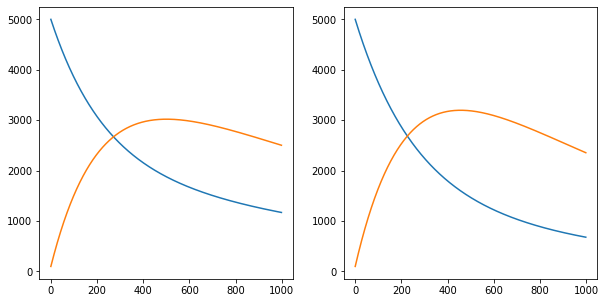

In [63]:
est_soln = odeint(fun,x0,time,args = (est_rs,))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(est_soln)
plt.subplot(122)
plt.plot(soln)
plt.show()

In [101]:
sel_times

array([  0,  71, 143, 214, 286, 357, 429, 500])

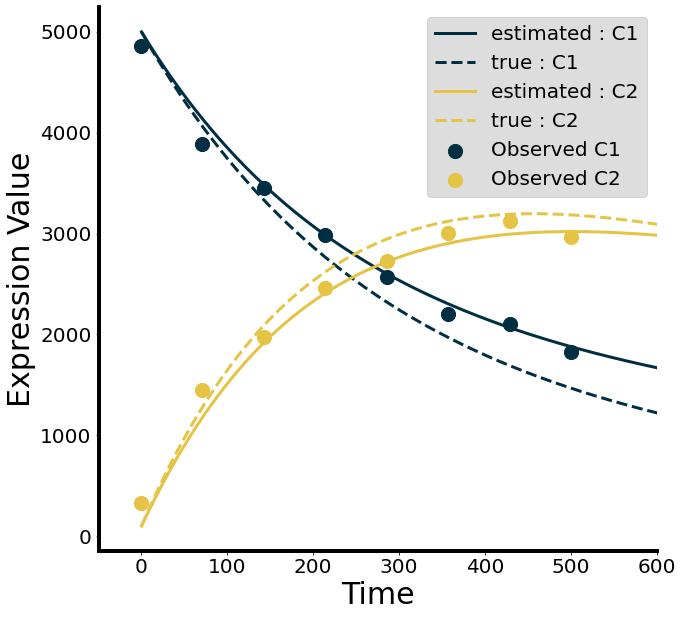

In [125]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
for k,(clr,compname) in enumerate(zip(["#002F43","#E5C344"],
                             ["C1","C2"])):
    
    ax.scatter(sel_times,
           time_data[:,k],
           c = clr,
           s = 200,
           label = "Observed " + compname,
           )
        
    for sol,linetype,solname in zip([est_soln,soln],["solid","dashed"],["estimated","true"]):
   
        ax.plot(sol[:,k],
                color = clr,
                linestyle = linetype,
                label = solname + " : " + compname,
                linewidth = 3,
               )
    
plt.setp(ax.get_xticklabels(), fontsize=20)  
plt.setp(ax.get_yticklabels(), fontsize=20)                                       

ax.legend(fontsize = 20, facecolor ="#D5D5D5")
ax.set_ylabel("Expression Value",fontsize = 30)
ax.set_xlabel("Time",fontsize = 30)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim([-50,600])
plt.show()


In [745]:
sode = ode.ODESolver(np.arange(5),
                     time_data,
                     time_data[0,:],
                     n_regions = n_regions,
                    )

fitted_res = sode.optim(p)

In [746]:
fitted_res["x"].reshape(n_regions,n_regions)

array([[  5.12234998,   0.15063399,   0.3583526 ,   0.26559534],
       [  1.49593892,   0.91597993,  -0.63815759,  -0.07109989],
       [  9.71429482,   0.70416961,  25.52667749,  -3.50784568],
       [-12.73208886,  -0.71819994,   9.20653101,  22.10342311]])

(-0.5, 3.5, 3.5, -0.5)

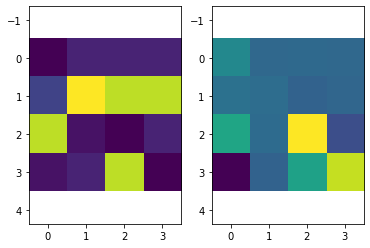

In [747]:
plt.subplot(121)
plt.imshow(rs)
plt.axis("equal")
plt.subplot(122)
plt.imshow(fitted_res["x"].reshape(n_regions,n_regions))
plt.axis("equal")

In [748]:
def f(y,t):
    x_new = np.zeros(n_regions)
    for ii in range(n_regions):
        for jj in range(n_regions):
            if ii != jj:
                x_new[ii] += y[jj]*pred_soln[jj,ii] - y[ii]*pred_soln[ii,jj]
            else:
                x_new[ii] += pred_soln[ii,ii]
    return x_new

In [749]:
pred_soln = odeint(f,time_data[0,:],sel_times)

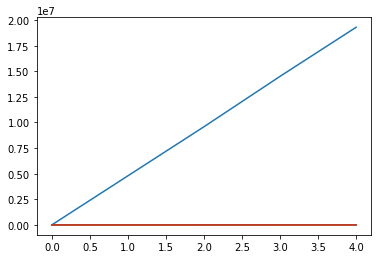

In [750]:
plt.plot(pred_soln)

In [797]:
from scipy.interpolate import griddata
def makeimg(crd,vals):
    mn_x,mn_y = crd.min(axis=0)
    mx_x,mx_y = crd.max(axis=0)
    n_space = int(np.ceil(np.sqrt(crd.shape[0])))
    xx = np.linspace(mn_x,mx_x,200)
    yy = np.linspace(mn_y,mx_y,200)
    xx,yy = np.meshgrid(xx,yy)
    return griddata(crd,vals,(yy,xx),fill_value=np.nan)
    